In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

rename_dict = {
    '用户编码':'id',
    '用户实名制是否通过核实':'is_realname_verified',
    '用户年龄':'age',
    '是否大学生客户':'is_college_student',
    '是否黑名单客户':'is_blacklisted',
    '是否4G不健康客户':'is_4G_unhealthy',
    '用户网龄（月）':'internet_age',
    '用户最近一次缴费距今时长（月）':'time_since_last_payment',
    '缴费用户最近一次缴费金额（元）':'last_payment',
    '用户近6个月平均消费值（元）':'avg_consumption_past6months',
    '用户账单当月总费用（元）':'total_bill_thismonth',
    '用户当月账户余额（元）':'account_balance_thismonth',
    '缴费用户当前是否欠费缴费':'is_owed',
    '用户话费敏感度':'charge_sensitivity', 
    '当月通话交往圈人数':'num_people_call_thismonth',
    '是否经常逛商场的人':'is_mall_often', 
    '近三个月月均商场出现次数':'avg_times_shown_mall', 
    '当月是否逛过福州仓山万达':'been_wanda_thismonth', 
    '当月是否到过福州山姆会员店':'been_sam_thismonth', 
    '当月是否看电影':'seen_movie_thismonth',
    '当月是否景点游览':'been_sightseeing_thismonth', 
    '当月是否体育场馆消费':'been_stadium_consumed_thismonth', 
    '当月网购类应用使用次数':'times_online_shopping_apps', 
    '当月物流快递类应用使用次数':'times_express_apps',
    '当月金融理财类应用使用总次数':'times_finance_apps', 
    '当月视频播放类应用使用次数':'times_video_apps', 
    '当月飞机类应用使用次数':'times_fight_apps', 
    '当月火车类应用使用次数':'times_train_apps',
    '当月旅游资讯类应用使用次数':'times_travel_apps', 
    '信用分':'credit',
}

In [3]:
train,test = pd.read_csv('train.csv'),pd.read_csv('test.csv')

In [4]:
train.dtypes

id                                  object
is_realname_verified                 int64
age                                  int64
is_college_student                   int64
is_blacklisted                       int64
is_4G_unhealthy                      int64
internet_age                         int64
time_since_last_payment              int64
last_payment                       float64
avg_consumption_past6months        float64
total_bill_thismonth               float64
account_balance_thismonth            int64
is_owed                              int64
charge_sensitivity                   int64
num_people_call_thismonth            int64
is_mall_often                        int64
avg_times_shown_mall                 int64
been_wanda_thismonth                 int64
been_sam_thismonth                   int64
seen_movie_thismonth                 int64
been_sightseeing_thismonth           int64
been_stadium_consumed_thismonth      int64
times_online_shopping_apps           int64
times_expre

In [5]:
data = pd.concat([train,test], ignore_index=True)

In [6]:
data.head()

,id,is_realname_verified,age,is_college_student,is_blacklisted,is_4G_unhealthy,internet_age,time_since_last_payment,last_payment,avg_consumption_past6months,...,been_sightseeing_thismonth,been_stadium_consumed_thismonth,times_online_shopping_apps,times_express_apps,times_finance_apps,times_video_apps,times_fight_apps,times_train_apps,times_travel_apps,credit
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,...,1,1,713,0,2740,7145,0,0,30,664.0
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,...,0,0,414,0,2731,44862,0,0,0,530.0
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,...,0,0,3391,0,0,4804,0,0,1,643.0
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,...,1,1,500,0,1931,3141,0,0,5,649.0
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,...,1,0,522,0,64,59,0,0,0,648.0


In [7]:
len(data)

100000

In [8]:
#some features are masked by 0, recover
data.loc[data.age==0, 'age'] = None
data.loc[data.charge_sensitivity==0, 'charge_sensitivity'] = data.charge_sensitivity.median()
data.internet_age = data.internet_age.apply(lambda x: x/12)

In [9]:
trn_data, test_data = data[:len(train)],data[len(train):]

In [10]:
from sklearn.model_selection import train_test_split
trn_data.drop(['id','age',], axis=1, inplace=True)

/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
del test_data['credit']

In [12]:
target = trn_data['credit']
del trn_data['credit']

In [13]:
X_trn, X_val, y_trn, y_val = train_test_split(trn_data, target, test_size=0.2)

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
def base_model(regressor, X_trn, X_val, y_trn, y_val,K_fold=5,Scale=False):
    X_trn, y_trn = X_trn.to_numpy(), y_trn.to_numpy()
    X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
    scaler = StandardScaler()
    if Scale:
        pipe = Pipeline([('PreTransformer', scaler),\
            ('Regressor', regressor)])
    else:
        pipe = Pipeline([('Regressor', regressor)])
    print(pipe)

    y_pred = np.zeros_like(y_val)
    folds = KFold(n_splits=K_fold,shuffle=True,random_state=0)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_trn, y_trn)):
        print(f"\n======fold No.{fold_+1}======")
        print('CV train_sample size : %d' % len(trn_idx))
        trn_X, trn_y = X_trn[trn_idx], y_trn[trn_idx]
        val_X, val_y = X_trn[val_idx], y_trn[val_idx]
        #fit
        pipe.fit(trn_X, trn_y)
        #predict on k_fold splitted val_X
        val_y_pred = pipe.predict(val_X)
        print('CV MAE Loss: %.2f' % mean_absolute_error(val_y_pred, val_y))
        #predict on X_val
        y_pred += pipe.predict(X_val)
    #div K-fold number
    y_pred /= K_fold
    #final metric on val-set
    MAE = mean_absolute_error(y_pred, y_val)
    print('\nMAE Loss: %.5f' % MAE)
    print('Final Score: %.5f' % (1/(1+MAE)))

In [22]:
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.neural_network import *

In [27]:
base_model(regressor, X_trn, X_val, y_trn, y_val, K_fold=10, Scale=True)

In [16]:
def ensemble_model(regressor, X_trn, X_val, y_trn, y_val, Scale=True):
    X_trn, y_trn = X_trn.to_numpy(), y_trn.to_numpy()
    X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
    scaler = StandardScaler()
    if Scale:
        pipe = Pipeline([('PreTransformer', scaler),\
            ('Regressor', regressor)])
    else:
        pipe = Pipeline([('Regressor', regressor)])
    print(pipe)

    pipe.fit(X_trn, y_trn)
    y_pred = pipe.predict(X_val)
    MAE = mean_absolute_error(y_pred, y_val)
    print('\nMAE Loss: %.5f' % MAE)
    print('Final Score: %.5f' % (1/(1+MAE)))
    return MAE



In [60]:
regressor = GradientBoostingRegressor(random_state=0, subsample=0.5, learning_rate=0.2)
ensemble_model(regressor, X_trn, X_val, y_trn, y_val, Scale=True)

Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 GradientBoostingRegressor(learning_rate=0.2, random_state=0,
                                           subsample=0.5))])

MAE Loss: 15.72745
Final Score: 0.05978


15.727452040504577

In [53]:
maes = []
for n in range(10,100):
    regressor = ExtraTreesRegressor(random_state=0, n_estimators=n)
    print('\n Num estimators: %d' % n)
    mae = ensemble_model(regressor, X_trn, X_val, y_trn, y_val, Scale=True)
    maes.append(mae)


 Num estimators: 10
Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 ExtraTreesRegressor(n_estimators=10, random_state=0))])

MAE Loss: 17.02955
Final Score: 0.05546

 Num estimators: 11
Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 ExtraTreesRegressor(n_estimators=11, random_state=0))])

MAE Loss: 16.94227
Final Score: 0.05573

 Num estimators: 12
Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 ExtraTreesRegressor(n_estimators=12, random_state=0))])

MAE Loss: 16.85755
Final Score: 0.05600

 Num estimators: 13
Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 ExtraTreesRegressor(n_estimators=13, random_state=0))])

MAE Loss: 16.79085
Final Score: 0.05621

 Num estimators: 14
Pipeline(steps=[('PreTransformer', StandardScaler()),
                ('Regressor',
                 Ex

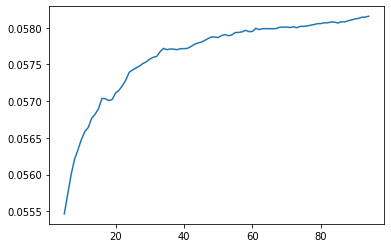

In [54]:
def plot(maes):
    scores = 1/(np.asarray(maes)+1)
    sns.lineplot(x=range(5,5+len(maes)),y=scores)
plot(maes)

In [1]:
def RFEmbed_model(regressor, X_trn, X_val, y_trn, y_val):
    X_trn, y_trn = X_trn.to_numpy(), y_trn.to_numpy()
    X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
    pipe = make_pipeline(
        StandardScaler(),
        RandomTreesEmbedding(),
        regressor,
    )
    print(pipe)

    pipe.fit(X_trn, y_trn)
    y_pred = pipe.predict(X_val)
    MAE = mean_absolute_error(y_pred, y_val)
    print('\nMAE Loss: %.5f' % MAE)
    print('Final Score: %.5f' % (1/(1+MAE)))

def gridCV_GBR(X_trn, X_val, y_trn, y_val, Scale=True):
    
    X_trn, y_trn = X_trn.to_numpy(), y_trn.to_numpy()
    X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
    scaler = StandardScaler()
    GBR = GradientBoostingRegressor(random_state=0)
    if Scale:
        pipe = Pipeline([('scaler', scaler),\
            ('GBR', GBR)])
    else:
        pipe = Pipeline([('GBR', GBR)])
    param_grid = {
        'GBR__learning_rate':[0.05,0.1,0.2,0.3],
        'GBR__subsample':[0.5,1.0]
    }
    search = GridSearchCV(pipe,param_grid,verbose=3)

    search.fit(X_trn, y_trn)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    print(search.best_estimator_)

KeyboardInterrupt: 